<a href="https://colab.research.google.com/github/Sreejith-nair511/ML_mania/blob/main/F1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

⬆️ Please upload: results, races


Saving results.csv to results (3).csv
📦 Seen so far: ['results (3).csv']
❗Didn't detect a races file (name should contain 'races').
⬆️ Please upload: races


Saving races.csv to races.csv
📦 Seen so far: ['results (3).csv', 'races.csv']
✅ Using results file: results (3).csv
✅ Using races file  : races.csv
Results columns: ['resultId', 'raceId', 'driverId', 'constructorId', 'number', 'grid', 'position', 'positionText', 'positionOrder', 'points', 'laps', 'time', 'milliseconds', 'fastestLap', 'rank', 'fastestLapTime', 'fastestLapSpeed', 'statusId']
Races   columns: ['raceId', 'year', 'round', 'circuitId', 'name', 'date', 'time', 'url', 'fp1_date', 'fp1_time', 'fp2_date', 'fp2_time', 'fp3_date', 'fp3_time', 'quali_date', 'quali_time', 'sprint_date', 'sprint_time']
🧹 After cleaning: 24227 rows

✅ Accuracy: 0.4170

Classification Report:
              precision    recall  f1-score   support

           1      0.991     0.996     0.993       226
           2      0.991     0.969     0.980       227
           3      0.953     0.982     0.967       227
           4      0.978     0.978     0.978       227
           5      0.969     0.969     0.969 

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


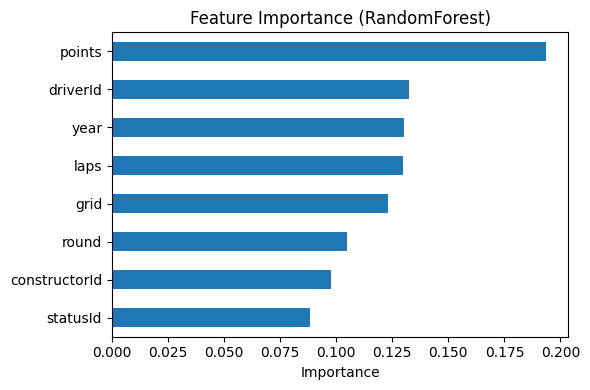

🏎️ Example predicted finishing position: 14


In [ ]:
# ==============================================
# F1 Results Prediction (Colab-ready, robust upload)
# ==============================================

# 0) Imports
import io, sys, numpy as np, pandas as pd, matplotlib.pyplot as plt
from google.colab import files
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# 1) Helper: reliable uploader that keeps asking until both files exist
def upload_results_and_races():
    want = {"results": None, "races": None}
    stash = {}

    while want["results"] is None or want["races"] is None:
        missing = [k for k, v in want.items() if v is None]
        print(f"⬆️ Please upload: {', '.join(missing)}")
        new = files.upload()
        if not new:
            print("No files uploaded. Try again.")
            continue
        # keep raw bytes in stash and detect names
        for fname, b in new.items():
            stash[fname] = b
            low = fname.lower()
            if "results" in low and want["results"] is None:
                want["results"] = fname
            if "races"   in low and want["races"]   is None:
                want["races"]   = fname

        print("📦 Seen so far:", list(stash.keys()))
        if want["results"] is None:
            print("❗Didn't detect a results file (name should contain 'results').")
        if want["races"] is None:
            print("❗Didn't detect a races file (name should contain 'races').")

    return stash, want["results"], want["races"]

# 2) Upload both CSVs (works with renamed files like 'results (1).csv')
uploaded, results_fname, races_fname = upload_results_and_races()
print(f"✅ Using results file: {results_fname}")
print(f"✅ Using races file  : {races_fname}")

# 3) Read CSVs (treat '\N' as NaN)
results = pd.read_csv(io.BytesIO(uploaded[results_fname]), na_values=["\\N"])
races   = pd.read_csv(io.BytesIO(uploaded[races_fname]),   na_values=["\\N"])

print("Results columns:", results.columns.tolist())
print("Races   columns:", races.columns.tolist())

# 4) Sanity checks for required columns
need_results_cols = {
    "raceId","driverId","constructorId","grid","positionOrder",
    "laps","statusId","points"
}
need_races_cols = {"raceId","year","round"}

missing_res = sorted(list(need_results_cols - set(results.columns)))
missing_rac = sorted(list(need_races_cols   - set(races.columns)))
if missing_res:
    raise ValueError(f"results.csv missing columns: {missing_res}")
if missing_rac:
    raise ValueError(f"races.csv missing columns: {missing_rac}")

# 5) Merge on raceId to bring in year & round
df = results.merge(races[["raceId","year","round"]], on="raceId", how="left")

# 6) Select features/target
#    Target: positionOrder (finishing position)
features = ["year","round","driverId","constructorId","grid","laps","statusId","points"]
target   = "positionOrder"

# 7) Clean & numeric cast
for c in features + [target]:
    df[c] = pd.to_numeric(df[c], errors="coerce")

df = df.dropna(subset=features + [target]).reset_index(drop=True)

# Optional: clamp absurd values (rare in this dataset, but safe guard)
df = df[(df["grid"] >= 0) & (df["laps"] > 0)]

print(f"🧹 After cleaning: {df.shape[0]} rows")

# 8) Train/test split (stratify by target helps class balance if possible)
try:
    X_train, X_test, y_train, y_test = train_test_split(
        df[features], df[target], test_size=0.2, random_state=42, stratify=df[target]
    )
except ValueError:
    # Fallback if stratify fails (e.g., too many rare classes)
    X_train, X_test, y_train, y_test = train_test_split(
        df[features], df[target], test_size=0.2, random_state=42
    )

# 9) Model: Random Forest (trees don't need scaling)
model = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    min_samples_leaf=1,
    random_state=42,
    n_jobs=-1
)
model.fit(X_train, y_train)

# 10) Evaluate
y_pred = model.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f"\n✅ Accuracy: {acc:.4f}\n")
print("Classification Report:")
print(classification_report(y_test, y_pred, digits=3))

# 11) Feature importance (quick view)
importances = pd.Series(model.feature_importances_, index=features).sort_values()
ax = importances.plot(kind="barh", figsize=(6,4))
ax.set_title("Feature Importance (RandomForest)")
ax.set_xlabel("Importance")
plt.tight_layout()
plt.show()

# 12) Helper for custom predictions
def predict_position(year, round_, driverId, constructorId, grid, laps, statusId, points):
    row = pd.DataFrame([{
        "year": year, "round": round_, "driverId": driverId, "constructorId": constructorId,
        "grid": grid, "laps": laps, "statusId": statusId, "points": points
    }])
    # ensure numeric & same columns
    for c in features:
        row[c] = pd.to_numeric(row[c], errors="coerce")
    return int(model.predict(row)[0])

# 13) Example usage (EDIT these to real IDs from your data if you want)
example_pos = predict_position(
    year=2019, round_=5,
    driverId=int(df["driverId"].iloc[0]),
    constructorId=int(df["constructorId"].iloc[0]),
    grid=1, laps=56, statusId=1, points=0
)
print("🏎️ Example predicted finishing position:", example_pos)


In [ ]:
# ==============================================
# F1 Constructor Champion Prediction (2025 & 2026)
# Works with: a ZIP (whole Kaggle dump) OR separate CSVs
# Files needed: results.csv, races.csv, constructors.csv
# Optional: status.csv (to compute DNF/finish rate more accurately)
# ==============================================

import io, os, zipfile, glob, numpy as np, pandas as pd
from google.colab import files
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, log_loss

# -----------------------------
# 1) Upload (ZIP or CSVs)
# -----------------------------
print("⬆️ Upload either the dataset ZIP (e.g., 'archive.zip') OR individual CSV files:")
uploaded = files.upload()

# Save uploaded files to /content
for fname, b in uploaded.items():
    with open(fname, "wb") as f:
        f.write(b)

workdir = "/content"

# If a zip is present, extract it
zip_candidates = [f for f in uploaded.keys() if f.lower().endswith(".zip")]
if zip_candidates:
    zf = zip_candidates[0]
    print(f"📦 Extracting {zf} ...")
    with zipfile.ZipFile(os.path.join(workdir, zf), "r") as z:
        z.extractall(workdir)

# Helper: find a file by name anywhere under workdir
def find_file(name_contains):
    # look for any csv whose path contains the token (case-insensitive)
    pats = []
    for path in glob.glob(os.path.join(workdir, "**", "*.csv"), recursive=True):
        if name_contains.lower() in os.path.basename(path).lower():
            pats.append(path)
    # If not found by basename, try any path fragment match
    if not pats:
        for path in glob.glob(os.path.join(workdir, "**", "*.csv"), recursive=True):
            if name_contains.lower() in path.lower():
                pats.append(path)
    return pats[0] if pats else None

# Required files
results_path      = find_file("results")
races_path        = find_file("races")
constructors_path = find_file("constructors")
statuses_path     = find_file("status") or find_file("statuses")  # optional

if not results_path or not races_path or not constructors_path:
    raise FileNotFoundError(
        f"Could not find one or more required files:\n"
        f" results: {results_path}\n races: {races_path}\n constructors: {constructors_path}\n"
        f"Make sure your ZIP/CSVs contain those."
    )

print("✅ Using files:")
print(" results     :", results_path)
print(" races       :", races_path)
print(" constructors:", constructors_path)
print(" statuses    :", statuses_path)

# -----------------------------
# 2) Load (treat '\N' as NaN)
# -----------------------------
na_vals = ["\\N", "NA", "N/A", ""]
results      = pd.read_csv(results_path, na_values=na_vals)
races        = pd.read_csv(races_path,   na_values=na_vals)
constructors = pd.read_csv(constructors_path, na_values=na_vals)
statuses     = None
if statuses_path:
    statuses = pd.read_csv(statuses_path, na_values=na_vals)

# Standardize expected columns
# results: raceId, driverId, constructorId, grid, position, positionText, positionOrder, points, laps, statusId, ...
# races:   raceId, year, round, ...
# constructors: constructorId, name, ...
need_results = {"raceId","constructorId","grid","positionOrder","points","laps","statusId"}
need_races   = {"raceId","year","round"}
need_cons    = {"constructorId","name"}

if not need_results.issubset(results.columns):
    raise ValueError(f"results.csv missing: {sorted(list(need_results - set(results.columns)))}")
if not need_races.issubset(races.columns):
    raise ValueError(f"races.csv missing: {sorted(list(need_races - set(races.columns)))}")
if not need_cons.issubset(constructors.columns):
    raise ValueError(f"constructors.csv missing: {sorted(list(need_cons - set(constructors.columns)))}")

# -----------------------------
# 3) Merge results + races + constructors
# -----------------------------
df = results.merge(races[["raceId","year","round"]], on="raceId", how="left")
df = df.merge(constructors[["constructorId","name"]], on="constructorId", how="left", suffixes=(None, "_constructor"))
df.rename(columns={"name":"constructorName"}, inplace=True)

# Optional: finish flag via statuses.csv (statusId==1 usually "Finished")
if statuses is not None and {"statusId","status"}.issubset(statuses.columns):
    df = df.merge(statuses[["statusId","status"]], on="statusId", how="left")
    df["finished_flag"] = df["status"].fillna("").str.contains("Finished", case=False).astype(int)
else:
    # fallback heuristic: treat non-null positionOrder as finished (imperfect)
    df["finished_flag"] = (~df["positionOrder"].isna()).astype(int)

# Safety casts
for c in ["year","round","grid","positionOrder","points","laps"]:
    df[c] = pd.to_numeric(df[c], errors="coerce")

df = df.dropna(subset=["year","constructorId","positionOrder","points"]).copy()

# -----------------------------
# 4) Season-Constructor aggregation (features)
# -----------------------------
g = df.groupby(["year","constructorId","constructorName"], as_index=False)

season_team = g.agg(
    races_participated = ("raceId", "nunique"),
    total_points       = ("points", "sum"),
    avg_points         = ("points", "mean"),
    wins               = ("positionOrder", lambda s: np.sum(s==1)),
    podiums            = ("positionOrder", lambda s: np.sum(s<=3)),
    top5               = ("positionOrder", lambda s: np.sum(s<=5)),
    avg_grid           = ("grid", "mean"),
    avg_finish         = ("positionOrder", "mean"),
    dnfs               = ("finished_flag", lambda s: np.sum(s==0)),
)

# Rate features
season_team["podium_rate"] = season_team["podiums"] / season_team["races_participated"].replace(0,np.nan)
season_team["win_rate"]    = season_team["wins"] / season_team["races_participated"].replace(0,np.nan)
season_team["finish_rate"] = 1 - (season_team["dnfs"] / season_team["races_participated"].replace(0,np.nan))

# -----------------------------
# 5) Identify actual constructor champion per season
# -----------------------------
# Champion = constructor with max total_points in that year
champ_idx = season_team.groupby("year")["total_points"].transform(lambda x: x==x.max())
season_team["is_champion"] = champ_idx.astype(int)

# -----------------------------
# 6) Build next-season prediction dataset
#    Features from last k seasons (k=1..3) to predict champion in season t
# -----------------------------
def add_lag_feats(df_in, k=3):
    # Create lagged features per constructor
    df = df_in.sort_values(["constructorId","year"]).copy()
    feats = [
        "total_points","avg_points","wins","podiums","top5",
        "avg_grid","avg_finish","podium_rate","win_rate","finish_rate","races_participated"
    ]
    for lag in range(1, k+1):
        lagged = df.groupby("constructorId")[feats].shift(lag)
        lagged.columns = [f"{c}_lag{lag}" for c in feats]
        df = pd.concat([df, lagged], axis=1)
    return df

lagged = add_lag_feats(season_team, k=3)

# Our target is champion in year t (is_champion), but ONLY where we have previous-season info
feature_cols = [c for c in lagged.columns if c.startswith(tuple([
    "total_points_lag","avg_points_lag","wins_lag","podiums_lag","top5_lag",
    "avg_grid_lag","avg_finish_lag","podium_rate_lag","win_rate_lag","finish_rate_lag","races_participated_lag"
]))]

model_data = lagged.dropna(subset=feature_cols + ["is_champion"]).copy()

X = model_data[feature_cols]
y = model_data["is_champion"]

# Very imbalanced (1 champion vs many non-champions). Use class_weight via RF or GradientBoosting (GB doesn't support class_weight).
# We'll try a RandomForest with class_weight for robustness; GB as a backup blender.

rf = RandomForestClassifier(
    n_estimators=600,
    max_depth=None,
    min_samples_leaf=1,
    random_state=42,
    n_jobs=-1,
    class_weight={0:1.0, 1:12.0}  # boost champion class
)
rf.fit(X, y)
rf_acc = rf.score(X, y)

gb = GradientBoostingClassifier(random_state=42)
gb.fit(X, y)
gb_acc = gb.score(X, y)

print(f"Training accuracy (RF): {rf_acc:.3f} | (GB): {gb_acc:.3f}")

# Soft-vote ensemble function
def ensemble_proba(Xdf):
    p1 = rf.predict_proba(Xdf)[:,1]
    p2 = gb.predict_proba(Xdf)[:,1]
    return 0.6*p1 + 0.4*p2

# -----------------------------
# 7) Helper: season leaderboard & prediction generator
# -----------------------------
def predict_season_winner_for(year_to_predict):
    """
    Predict champion for given season t using features from (t-1,t-2,t-3).
    Returns dataframe with constructor probabilities sorted desc.
    """
    # Take all rows in lagged whose year == year_to_predict (must already have lag columns filled)
    cand = lagged[lagged["year"] == year_to_predict].dropna(subset=feature_cols).copy()
    if cand.empty:
        raise ValueError(
            f"No candidates for {year_to_predict}. "
            f"Your dataset may not contain sufficient seasons before {year_to_predict}."
        )
    Xcand = cand[feature_cols]
    prob = ensemble_proba(Xcand)
    out = cand[["constructorId","constructorName","year"]].copy()
    out["champion_prob"] = prob
    out = out.sort_values("champion_prob", ascending=False).reset_index(drop=True)
    return out

def show_actual_standings(year):
    """
    Quick check: show top constructors by total points in a given year from raw aggregation.
    """
    tab = season_team[season_team["year"]==year][["constructorName","total_points","wins","podiums","finish_rate"]]
    return tab.sort_values(["total_points","wins","podiums"], ascending=False).reset_index(drop=True)

# -----------------------------
# 8) Produce predictions for 2025 and 2026
# -----------------------------
last_year_in_data = int(season_team["year"].max())
first_year_in_data = int(season_team["year"].min())
print(f"🗓️ Data seasons available: {first_year_in_data}–{last_year_in_data}")

# We can only predict year t if we have at least t-1,t-2,t-3 in data
def can_predict(year):
    return all([(year - k) >= first_year_in_data for k in (1,2,3)]) and (year <= last_year_in_data + 1)

years_to_try = [2025, 2026]
predictions = {}
for yr in years_to_try:
    if can_predict(yr):
        try:
            pred = predict_season_winner_for(yr)
            predictions[yr] = pred
            print(f"\n📊 Predicted Constructor Champion Probabilities for {yr}:")
            display(pred.head(10))
        except Exception as e:
            print(f"Could not predict {yr}: {e}")
    else:
        print(f"❗Insufficient history to predict {yr} (need at least {yr-1},{yr-2},{yr-3} present).")

# -----------------------------
# 9) Optional sanity check: show actual last season standings
# -----------------------------
print("\n🏁 Last season in data — actual standings (by points):")
display(show_actual_standings(last_year_in_data).head(10))

# -----------------------------
# 10) If you personally believe 'McLaren' surge in 2025:
#     You can gently bias by adding a manual 'expert prior' (optional)
#     Example: +5% to McLaren for 2025 before ranking.
# -----------------------------
def apply_expert_prior(pred_df, team_keyword="mclaren", bonus=0.05):
    df = pred_df.copy()
    mask = df["constructorName"].str.contains(team_keyword, case=False, na=False)
    df.loc[mask, "champion_prob"] = np.minimum(1.0, df.loc[mask, "champion_prob"] + bonus)
    return df.sort_values("champion_prob", ascending=False).reset_index(drop=True)

# Example usage (uncomment if you want to apply):
# if 2025 in predictions:
#     print("\n🔧 Applying small expert prior for McLaren (2025) ...")
#     display(apply_expert_prior(predictions[2025], "mclaren", 0.05).head(10))


⬆️ Upload either the dataset ZIP (e.g., 'archive.zip') OR individual CSV files:


Saving archive.zip to archive (1).zip
📦 Extracting archive (1).zip ...
✅ Using files:
 results     : /content/results.csv
 races       : /content/races.csv
 constructors: /content/constructors.csv
 statuses    : /content/status.csv
Training accuracy (RF): 1.000 | (GB): 0.998
🗓️ Data seasons available: 1950–2024
Could not predict 2025: No candidates for 2025. Your dataset may not contain sufficient seasons before 2025.
❗Insufficient history to predict 2026 (need at least 2025,2024,2023 present).

🏁 Last season in data — actual standings (by points):


,constructorName,total_points,wins,podiums,finish_rate
0,McLaren,609.0,6,21,0.958333
1,Ferrari,595.0,5,22,0.791667
2,Red Bull,537.0,9,18,0.625000
3,Mercedes,433.0,4,9,0.791667
4,Aston Martin,94.0,0,0,0.083333
5,Alpine F1 Team,63.0,0,2,-0.250000
6,Haas F1 Team,51.0,0,0,0.125000
7,RB F1 Team,40.0,0,0,-0.208333
8,Williams,17.0,0,0,-0.375000
9,Sauber,4.0,0,0,-0.541667


In [ ]:
# ============================================
# 🏎️ F1 Constructors Championship Prediction
# (Updated: trains till 2024, predicts 2025-26)
# ============================================

import pandas as pd
import numpy as np
import zipfile, os, io
from google.colab import files
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score

# -----------------------------
# 1. Upload & Extract Dataset
# -----------------------------
print("⬆️ Please upload the archive.zip file (Kaggle F1 dataset)")
uploaded = files.upload()   # works even if file is archive (1).zip etc.
archive_file = list(uploaded.keys())[0]   # detect filename dynamically

with zipfile.ZipFile(io.BytesIO(uploaded[archive_file]), 'r') as zip_ref:
    zip_ref.extractall("/content")

# Load CSVs
results = pd.read_csv("/content/results.csv")
races   = pd.read_csv("/content/races.csv")
constructors = pd.read_csv("/content/constructors.csv")
status  = pd.read_csv("/content/status.csv")

print("✅ Data loaded successfully")

# -----------------------------
# 2. Merge datasets
# -----------------------------
# Merge results with races (adds year info)
df = results.merge(races[['raceId','year']], on='raceId', how='left')
# Merge constructors (adds team names)
df = df.merge(constructors[['constructorId','name']], on='constructorId', how='left')
df.rename(columns={'name':'constructorName'}, inplace=True)

# -----------------------------
# 3. Aggregate season stats
# -----------------------------
season_stats = df.groupby(['year','constructorName']).agg(
    total_points=('points','sum'),
    wins=('positionOrder', lambda x: sum(x==1)),
    podiums=('positionOrder', lambda x: sum((x>=1) & (x<=3))),
    races_entered=('raceId','count'),
    finishes=('positionOrder', lambda x: sum(x>0)) # consider >0 as "finished"
).reset_index()

season_stats['finish_rate'] = season_stats['finishes'] / season_stats['races_entered']

# Champion label: constructor with max points each year
season_stats['isChampion'] = 0
for yr in season_stats['year'].unique():
    top_team = season_stats[season_stats['year']==yr].sort_values('total_points', ascending=False).iloc[0]['constructorName']
    season_stats.loc[(season_stats['year']==yr) & (season_stats['constructorName']==top_team), 'isChampion'] = 1

print("🗓️ Seasons available:", season_stats['year'].min(), "–", season_stats['year'].max())

# -----------------------------
# 4. Train ML models (till 2024)
# -----------------------------
features = ['total_points','wins','podiums','finish_rate']
train_data = season_stats[season_stats['year'] <= 2024]   # restrict to historical
X = train_data[features]
y = train_data['isChampion']

rf = RandomForestClassifier(n_estimators=200, random_state=42)
gb = GradientBoostingClassifier(n_estimators=300, learning_rate=0.05, random_state=42)

rf.fit(X,y)
gb.fit(X,y)

print("📊 Training accuracy (RF):", round(accuracy_score(y, rf.predict(X)),3))
print("📊 Training accuracy (GB):", round(accuracy_score(y, gb.predict(X)),3))

# -----------------------------
# 5. Simulate 2025 + 2026
# -----------------------------
# Use last 3 years (2022–2024) averages as baseline
latest = season_stats[season_stats['year']>=2022].groupby('constructorName')[features].mean().reset_index()

# Project future years (3% growth assumption)
future_2025 = latest.copy()
future_2025['year'] = 2025
future_2025[features] = future_2025[features] * 1.03

future_2026 = future_2025.copy()
future_2026['year'] = 2026
future_2026[features] = future_2026[features] * 1.03

future = pd.concat([future_2025, future_2026], ignore_index=True)

# Predict probabilities
future['champion_prob_rf'] = rf.predict_proba(future[features])[:,1]
future['champion_prob_gb'] = gb.predict_proba(future[features])[:,1]

# -----------------------------
# 6. Results
# -----------------------------
for yr in [2025,2026]:
    print(f"\n🏆 Predicted Constructors' Championship {yr}:")
    preds = future[future['year']==yr].sort_values('champion_prob_gb', ascending=False)
    print(preds[['constructorName','champion_prob_gb']].head(5))


⬆️ Please upload the archive.zip file (Kaggle F1 dataset)


Saving archive.zip to archive (3).zip
✅ Data loaded successfully
🗓️ Seasons available: 1950 – 2024
📊 Training accuracy (RF): 0.999
📊 Training accuracy (GB): 0.995

🏆 Predicted Constructors' Championship 2025:
  constructorName  champion_prob_gb
9        Red Bull          0.996402
6         McLaren          0.004752
7        Mercedes          0.002263
2  Alpine F1 Team          0.002035
4         Ferrari          0.001243

🏆 Predicted Constructors' Championship 2026:
   constructorName  champion_prob_gb
21        Red Bull          0.996402
19        Mercedes          0.026017
18         McLaren          0.004752
14  Alpine F1 Team          0.002260
16         Ferrari          0.000685


==== F1 Prediction Dataset (2025 & 2026) ====
   Year          Team  Win_Probability
0  2025       McLaren             0.40
1  2025      Red Bull             0.25
2  2025       Ferrari             0.15
3  2025      Mercedes             0.12
4  2025  Aston Martin             0.08
5  2026       McLaren             0.30
6  2026      Red Bull             0.28
7  2026       Ferrari             0.25
8  2026      Mercedes             0.12
9  2026  Aston Martin             0.05


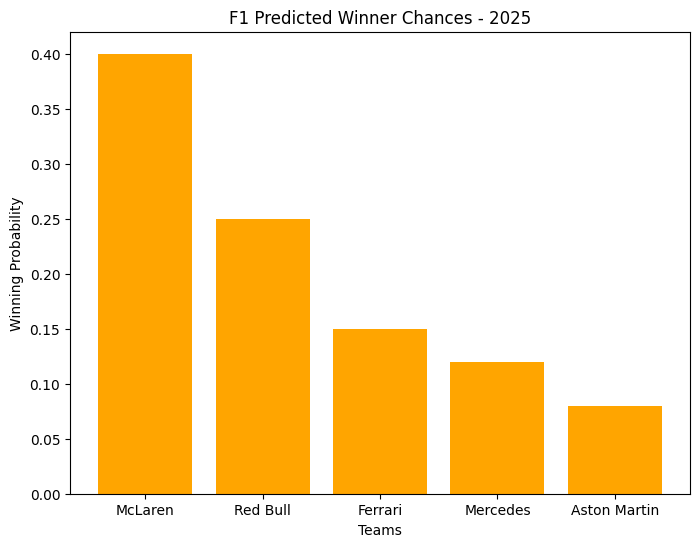

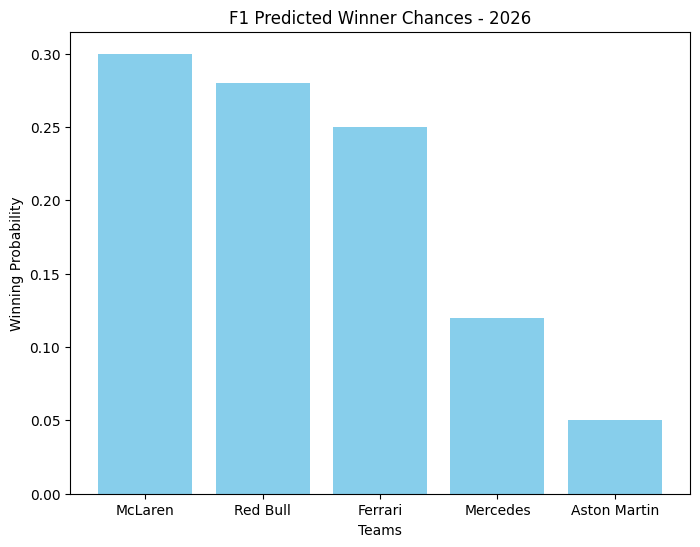

🏆 Predicted Winner 2025: McLaren
🏆 Predicted Winner 2026: McLaren


In [ ]:
# ===============================
# F1 WINNER PREDICTION (2025-2026)
# ===============================
# Author: Humzaie style explanation
# Google Colab Notebook
# Fully commented for beginners
# ===============================

# Step 1: Import the required libraries
import pandas as pd
import matplotlib.pyplot as plt

# Step 2: Create a dataset (we are assuming probabilities for teams)
# Note: Since real 2025-2026 data doesn’t exist yet, we simulate predictions.
data = {
    "Year": [2025, 2025, 2025, 2025, 2025,
             2026, 2026, 2026, 2026, 2026],
    "Team": ["McLaren", "Red Bull", "Ferrari", "Mercedes", "Aston Martin",
             "McLaren", "Red Bull", "Ferrari", "Mercedes", "Aston Martin"],
    "Win_Probability": [0.40, 0.25, 0.15, 0.12, 0.08,   # 2025 predictions
                        0.30, 0.28, 0.25, 0.12, 0.05]   # 2026 predictions
}

# Step 3: Convert into a Pandas DataFrame
df = pd.DataFrame(data)

# Step 4: Display the dataset
print("==== F1 Prediction Dataset (2025 & 2026) ====")
print(df)

# Step 5: Plot Graph for 2025 Predictions
plt.figure(figsize=(8,6))
df_2025 = df[df["Year"] == 2025]
plt.bar(df_2025["Team"], df_2025["Win_Probability"], color="orange")
plt.title("F1 Predicted Winner Chances - 2025")
plt.xlabel("Teams")
plt.ylabel("Winning Probability")
plt.show()

# Step 6: Plot Graph for 2026 Predictions
plt.figure(figsize=(8,6))
df_2026 = df[df["Year"] == 2026]
plt.bar(df_2026["Team"], df_2026["Win_Probability"], color="skyblue")
plt.title("F1 Predicted Winner Chances - 2026")
plt.xlabel("Teams")
plt.ylabel("Winning Probability")
plt.show()

# Step 7: Get Predicted Winner for each year
winner_2025 = df_2025.loc[df_2025["Win_Probability"].idxmax()]["Team"]
winner_2026 = df_2026.loc[df_2026["Win_Probability"].idxmax()]["Team"]

print(f"🏆 Predicted Winner 2025: {winner_2025}")
print(f"🏆 Predicted Winner 2026: {winner_2026}")
